In [171]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# below doesn't work on simult. kernel restart and run all
plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams.update({'font.size': 14})

### Q1 - Contrast Stretching

OpenCV does not support contrast stretching directly:
https://stackoverflow.com/questions/42257173/contrast-stretching-in-python-opencv

Displaying images with imshow():
https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad

`pixel_b, pixel_g, pixel_r = image[row][column]`

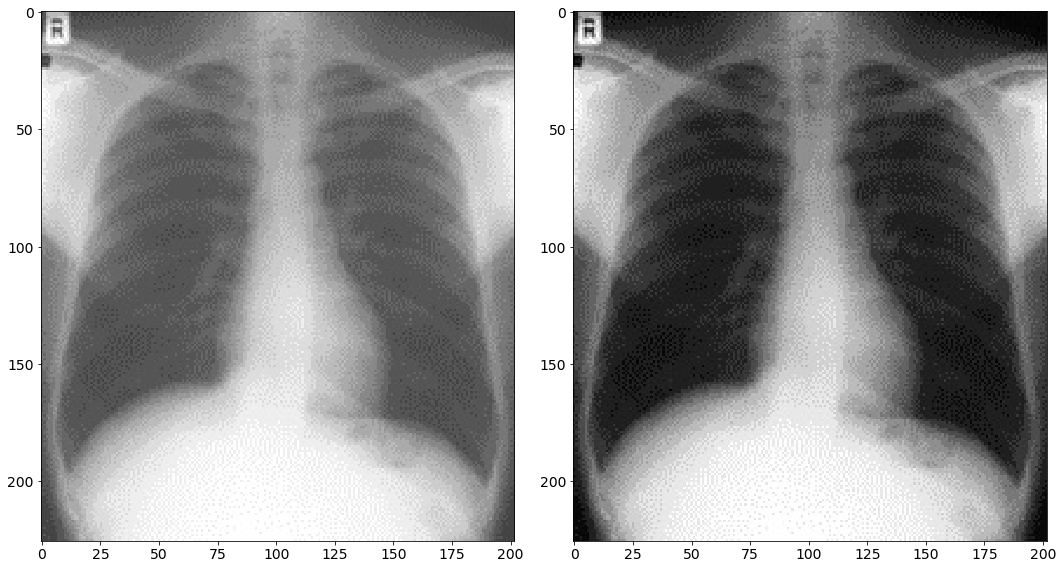

In [172]:
def contrastStretch(img):
    pixel_type = type(img[0][0][0])
    pixel_info = np.iinfo(pixel_type)
    a,b = pixel_info.min, pixel_info.max
    #ndim = img.shape[2] # assume 2D multichannel
    #for channel_index in range(0, ndim):         # unsure on .apply() use
    #channel = img[:,:,channel_index]  
    c,d = np.amin(img), np.amax(img) # min, max present
    #print(a,b,c,d)
    newimg = (img.astype(np.float64) - c) * (b - a)/(d - c) + a
    return newimg.astype(pixel_type)
    
    #newimg = np.zeros(img.shape,dtype=pixel_type)
    #for ri in range(0, img.shape[0]):             # inefficient
    #    for ci in range(0, img.shape[1]):
    #        newimg[ri][ci] = (img[ri][ci] - c) * float(b - a)/(d - c) + a

q1_img = cv2.imread('imageQ1.jpg')
q1_res = contrastStretch(q1_img)
#cv2.imwrite('imageQ1_result.jpg', q1_res)

plt.subplot(1,2,1)
plt.imshow(q1_img)
plt.subplot(1,2,2)
plt.imshow(q1_res)

plt.tight_layout()
plt.show()

### Q2 - Histogram Matching

NOTE: Image pixel intensity results in clipping in matplotlib.pyplot if the image pixels are not of the correct dtype (i.e. uint8_t).

`np.histogram()`: https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html

 * All but the last (righthand-most) bin is half-open.

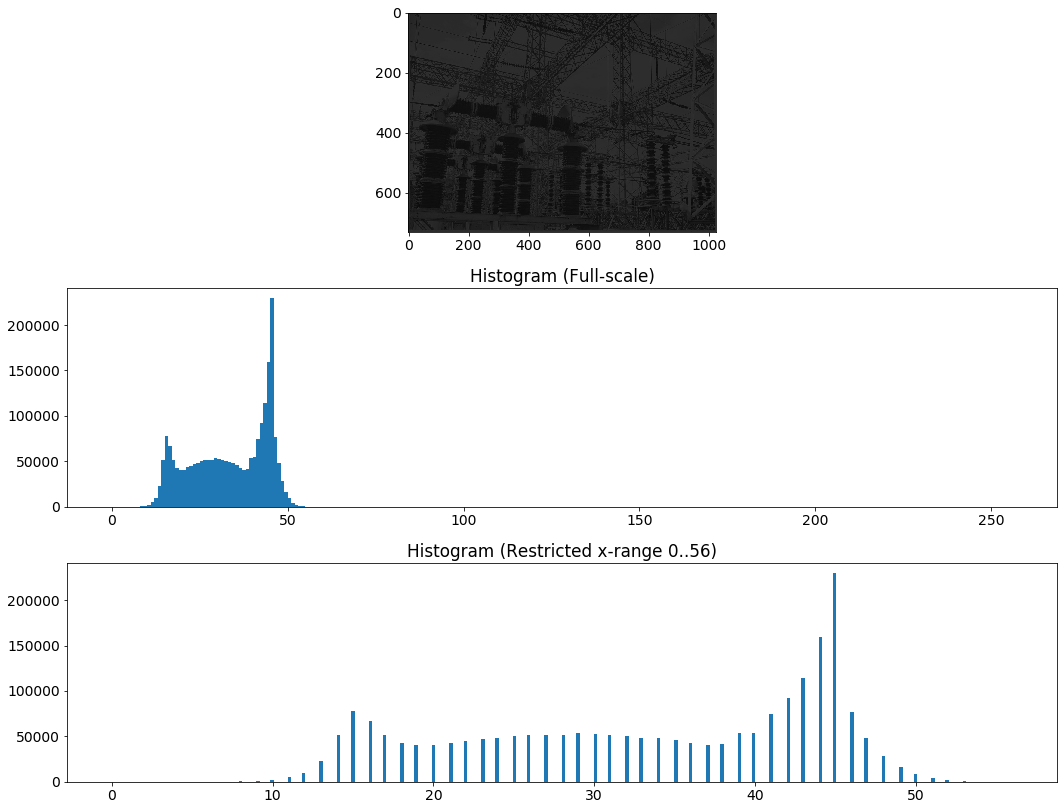

In [173]:
q2_refimg = cv2.imread('imageQ21.jpg')
plt.subplot(4,1,1)
plt.imshow(q2_refimg)

# in-built cv2 histogram function
# https://docs.opencv.org/master/d1/db7/tutorial_py_histogram_begins.html
#q2_cvhist = cv2.calcHist([q2_img], [0], None, [256], [0,256]) 
# ^ hard to plot; used more so in generating specialised histogram plots

# matplotlib histogram function
# https://www.datacamp.com/community/tutorials/histograms-matplotlib
plt.subplot(4,1,2)
plt.title('Histogram (Full-scale)')
plt.hist(q2_refimg.ravel(), 256, [0,256]) # full scale

plt.subplot(4,1,3)
plt.title('Histogram (Restricted x-range 0..56)')
q2_refhist = plt.hist(q2_refimg.ravel(), 256, [0,56]) # bins, range

# https://scientificallysound.org/2016/06/09/matplotlib-how-to-plot-subplots-of-unequal-sizes/
# https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
plt.tight_layout() # stops images overlapping on each other
plt.show()

Template (Reference):
rk    | nk    | pr(rk)| sk    
  5.00|   8889| 0.0040|   0.00
 11.50| 280602| 0.1251|   1.00
 18.00| 307512| 0.1371|   2.00
 24.50| 310497| 0.1385|   3.00
 31.00| 328233| 0.1464|   4.00
 37.50| 431667| 0.1925|   5.00
 44.00| 567294| 0.2530|   7.00
 50.50|   7866| 0.0035|   7.00
#values: 2242560

Source:
rk    | nk    | pr(rk)| sk    
  0.00|  22845| 0.1504|   1.00
 31.88|  12579| 0.0828|   2.00
 63.75|  20361| 0.1341|   3.00
 95.62|  23970| 0.1578|   4.00
127.50|  31446| 0.2071|   5.00
159.38|  20595| 0.1356|   6.00
191.25|  10413| 0.0686|   7.00
223.12|   9666| 0.0636|   7.00
#values: 151875



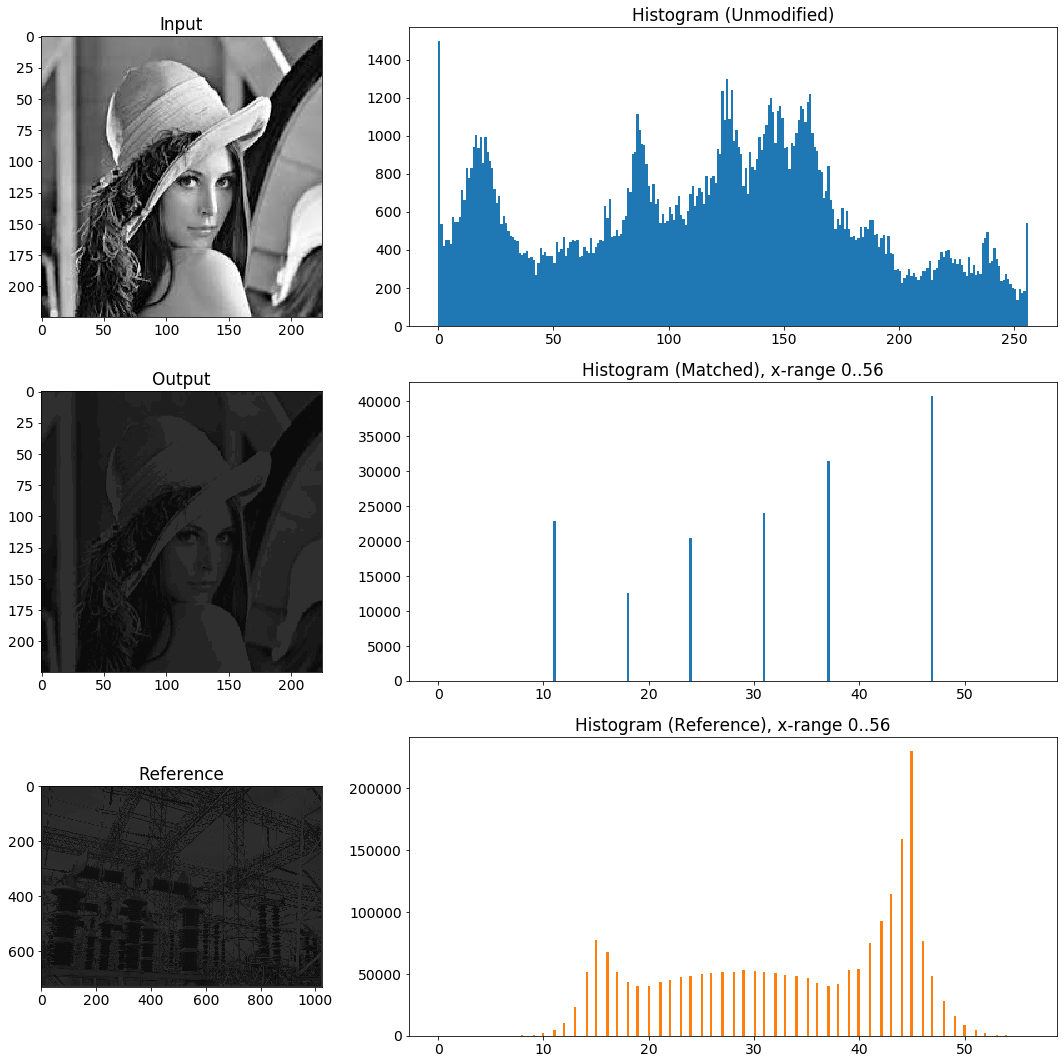

In [174]:
# Question 2.2
# https://theailearner.com/2019/04/10/histogram-matching-specification/

# Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
# Note: function only logically works for greyscale / 1-channel at a time
# (asked tutor - this method is too good for this task)
def hist_match(source, template):
    pixel_type = type(source[0][0][0])
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    # * (can be later reshaped to 2D image if pixel order does not change)

    # get the set of unique pixel values and their corresponding 
    # indices and counts (better than doing a histogram as this tells
    # you where the pixels are located)
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    # * (return_inverse) --> returns indices for that unique value
    #      --> you can reconstruct ar from all the collected indices
    # * (only need to match indexes of src image to template's histogram)
    
    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    # * (cumsum just does a sums of: cur_val + prev_vals, per iteration)
    # * (i.e. from lecture slides, nk(s_counts) / MN(total_pixels))
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(pixel_type)
    # * (vals in a 3 channel greyscale img are triple-counted; seems safe)

    return interp_t_values[bin_idx].reshape(oldshape) # cast back to 2D img


# ************************************
def print_table(label, nk, rk, prrk, sk):
    print("{}:".format(label))
    print("{:6}| {:6}| {:6}| {:6}".format("rk", "nk", "pr(rk)", "sk"))
    for i in range(len(nk)):
        print("{:6.2f}| {:6}| {:6.4f}| {:6.2f}".format(rk[i], nk[i], prrk[i], sk[i]))
    print("#values:", np.sum(nk))
    print("")
        
def get_histmatch_table(temp, hist_bins, label):
    # creates temp lookup table
    temp_nk, temp_rk = np.histogram(temp, hist_bins)
    prrk = temp_nk.astype(np.float64)/np.sum(temp_nk)
    temp_sk = (hist_bins-1) * np.cumsum(prrk)
    temp_skround = np.around(temp_sk).astype(np.uint8) # comparison uint
    print_table(label, temp_nk, temp_rk, prrk, temp_skround)
    return temp_nk, temp_rk, temp_skround

def pairwise_average(npl):
    npl = npl.astype(np.float64)
    return np.array([(npl[i] + npl[i+1])/2 for i in range(len(npl)-1)])

# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# https://stackoverflow.com/questions/8768540/how-to-find-last-occurrence-of-maximum-value-in-a-numpy-ndarray/8768734
def find_nearest(array, value):
    array = np.asarray(array)
    idx = len(array) - (np.abs(array - value)[::-1]).argmin() - 1
    return array[idx]

# (direct lecture eqn implem.: match to 8 bins)
def hist_match_lect(src, temp): 
    pixel_type = type(src[0][0][0])
    color_channels = [0] # assume greyscale imgs
    hist_bins = 8
    # temp lookup table
    temp_nk, temp_rk, temp_sk = get_histmatch_table(temp, hist_bins, "Template (Reference)")
    
    # ** pairwise avg of indiv. bin edges, s.t. len(temp_rk) == len(temp_nk)
    #temp_rk = np.around(pairwise_average(temp_rk)).astype(pixel_type)
    
    # ** then, we take avg of all vals in temp_rk in same class (as classified by temp_sk)
    pixel_replacement_dict = {}
    for sk_val in np.unique(temp_sk):
        class_indexes = np.argwhere(temp_sk == sk_val)
        pixel_replacement_dict[sk_val] = np.mean(temp_rk[class_indexes])
        # ^ TODO: (might need to be more sophisticated here to match the img)
    
    # src lookup table
    src_nk, src_rk, src_sk = get_histmatch_table(src, hist_bins, "Source")
    
    # * match src_sk to nearest value in temp_sk
    matching_bin = src_sk
    for i in range(len(matching_bin)):
        matching_bin[i] = find_nearest(temp_sk, matching_bin[i])
    
    # * foreach: match each pixel in src img to corresponding bin in src_sk
    # * foreach: replace pixel
    def replace_pixel(pixel_value):
        # match pixel to correct src_rk bin
        bin_index = hist_bins -1
        for i in range(len(src_rk)-1):
            if pixel_value >= src_rk[i] and pixel_value < src_rk[i+1]:
                bin_index = i
                break
        # match src_rk bin to matching_bin
        # replace pixel using matching_bin
        return pixel_replacement_dict[ matching_bin[ bin_index ] ]
        # ^ TODO: (might need to be more sophisticated here to match the img)
        
    oldshape = src.shape
    newsrc = src.ravel()
    for i in range(len(newsrc)):
        newsrc[i] = replace_pixel(newsrc[i])
    #newsrc = np.apply_along_axis(replace_pixel, 0, np.asarray(src.ravel()))   # doesnt work
    return newsrc.reshape(oldshape)

    
# ************************************
q2_lady = cv2.imread('imageQ22.jpg')
plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(q2_lady)

plt.subplot(3,3,(2,3))
plt.title('Histogram (Unmodified)')
plt.hist(q2_lady.ravel(), 256, [0,256])

#q2_newlady = hist_match(q2_lady, q2_refimg)            # <----- works better
q2_newlady = hist_match_lect(q2_lady, q2_refimg)
plt.subplot(3,3,4)
plt.title('Output')
plt.imshow(q2_newlady)

plt.subplot(3,3,(5,6))
plt.title('Histogram (Matched), x-range 0..56')
plt.hist(q2_newlady.ravel(), 256, [0,56])

plt.subplot(3,3,7)
plt.title('Reference')
plt.imshow(q2_refimg)

plt.subplot(3,3,(8,9))
plt.title('Histogram (Reference), x-range 0..56')
plt.hist(q2_refimg.ravel(), 256, [0,56])
plt.hist(q2_refimg.ravel(), 256, [0,56])

plt.tight_layout()
plt.show()

### Question 3 - Image Filtering (Sobel operator)

matplotlib does not interpret greyscale images very well (no issues with the cv2 image viewer). A solution can be to specify the cmap argument when plotting.

To get both positive and negative edges, follow this tutorial regarding data types: https://docs.opencv.org/master/d5/d0f/tutorial_py_gradients.html

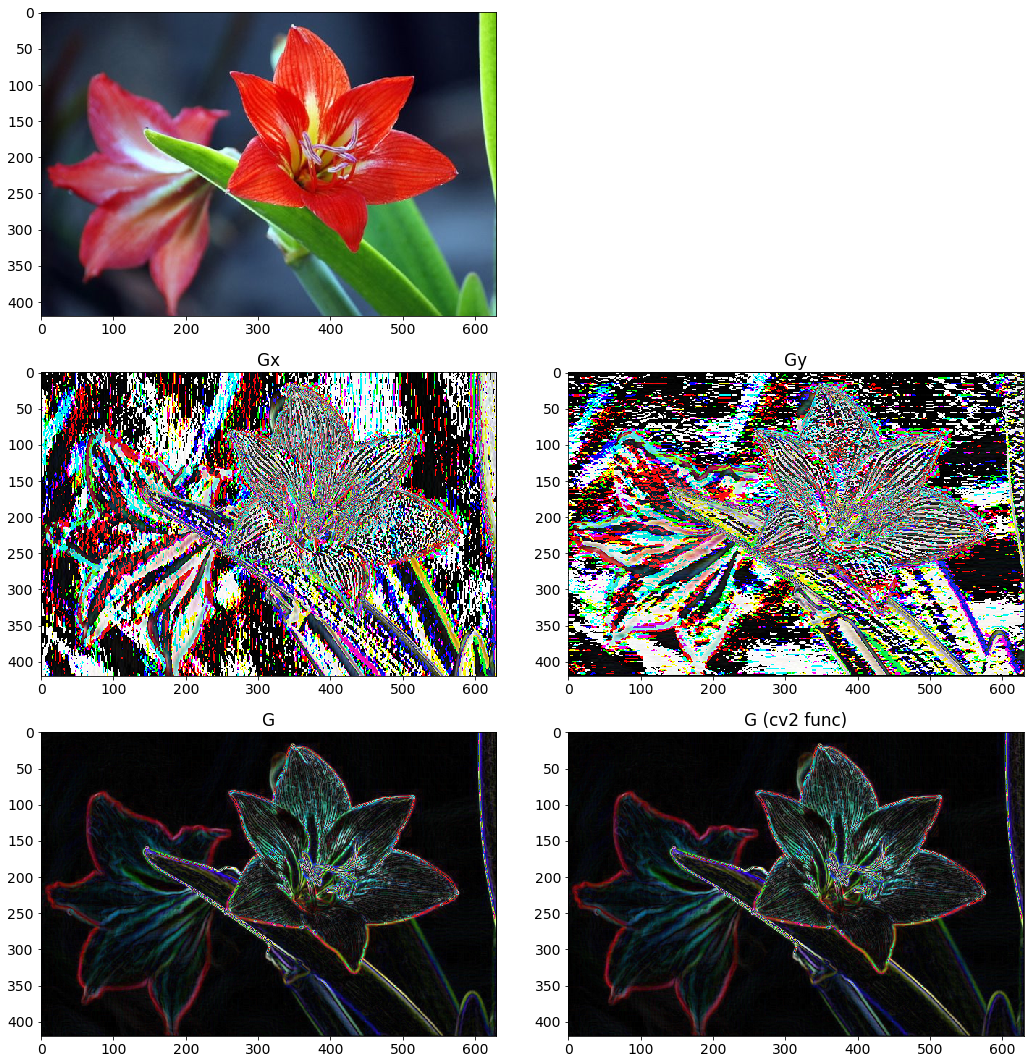

In [175]:
q3_img = cv2.imread('imageQ3.jpg')
q3_img = cv2.cvtColor(q3_img, cv2.COLOR_BGR2RGB) # palette swap
q3_pixel_type = type(q3_img[0][0][0])

# https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
Fx = np.array([ [-1, 0, 1], [-2,0,2], [-1,0,1] ])
Fy = np.array([ [-1,-2,-1], [ 0,0,0], [ 1,2,1] ]) # transpose of Fx

# too much noise/detail?
Gx = cv2.filter2D(q3_img.astype(np.float64), -1, Fx)
Gy = cv2.filter2D(q3_img.astype(np.float64), -1, Fy)

#G = (np.multiply(Gx, Gx)/4 + np.multiply(Gy, Gy)/4)  # same result as |Gx| + |Gy|
#G = np.sqrt(G).astype(q3_pixel_type)
G = (np.absolute(Gx/2) + np.absolute(Gy/2)).astype(q3_pixel_type)

Gcvx = cv2.Sobel(q3_img.astype(np.float64), -1, 1, 0)
Gcvy = cv2.Sobel(q3_img.astype(np.float64), -1, 0, 1)
Gcv = (np.absolute(Gcvx/2) + np.absolute(Gcvy/2)).astype(q3_pixel_type)

def isolateChannel(img, channel_index): # removes channels
    imgcpy = img.copy()
    for i in range(img.shape[2]): # assume 3 dimensional
        if (i == channel_index):
            continue
        imgcpy[:,:,i] = 0
    return cv2.cvtColor(imgcpy, cv2.COLOR_BGR2GRAY)

q3r = 3
q3c = 2
plt.subplot(q3r,q3c,1)
plt.imshow(q3_img)

q3_preoffset = 3
plt.subplot(q3r,q3c,q3_preoffset)
plt.title('Gx')
plt.imshow(Gx.astype(q3_pixel_type))
q3_preoffset += 1

plt.subplot(q3r,q3c,q3_preoffset)
plt.title('Gy')
plt.imshow(Gy.astype(q3_pixel_type))
q3_preoffset += 1

plt.subplot(q3r,q3c,q3_preoffset)
plt.title('G')
plt.imshow(G.astype(q3_pixel_type))
q3_preoffset += 1

plt.subplot(q3r,q3c,q3_preoffset)
plt.title('G (cv2 func)')
plt.imshow(Gcv)
q3_preoffset += 1

def q3_plot_components(q3_offset): # originally: q3r = q3c = 3
    q3_isolated = [isolateChannel(q3_img, 0), 
                   isolateChannel(q3_img, 1), isolateChannel(q3_img, 2)]
    q3_labels = 'RGB'
    
    # (left, top edges only)
    for q3i in range(0,len(q3_isolated)):
        plt.subplot(q3r, q3c, q3i + q3_offset)
        plt.title('Gx_' + q3_labels[q3i])
        plt.imshow(cv2.filter2D(q3_isolated[q3i], -1, Fx), cmap=plt.get_cmap('gray'))

    for q3j in range(0,len(q3_isolated)):
        plt.subplot(q3r, q3c, q3j + q3i + q3_offset + 1)
        plt.title('Gy_' + q3_labels[q3j])
        plt.imshow(cv2.filter2D(q3_isolated[q3j], -1, Fy), cmap=plt.get_cmap('gray'))

plt.tight_layout()
plt.show()

### Question 4 - Mean / Median / Gaussian Filtering

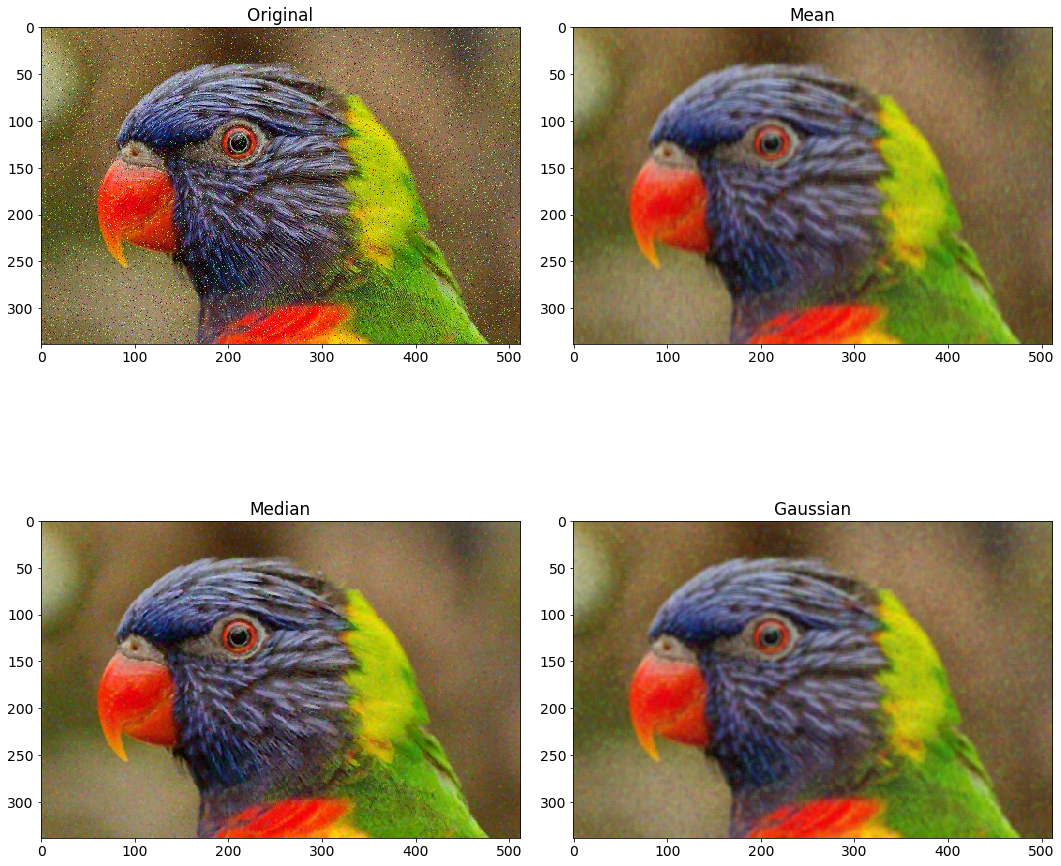

Median (at low values) seems to perform best, as it seems like it can preserve edges since it only copies a pixel value; i.e. it doesn't force creation of new pixel values.


In [176]:
# https://www.pyimagesearch.com/2016/07/25/convolutions-with-opencv-and-python/
# * (custom implem. is literally nested-for-loop w. array slicing as the cursor)

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
q4_img = cv2.cvtColor(cv2.imread('imageQ4.jpg'), cv2.COLOR_BGR2RGB)

q4_meankernsize = (4,6) # avging filter doesn't have to be square
q4_meanimg = cv2.blur(q4_img, q4_meankernsize)

q4_medimg = cv2.medianBlur(q4_img, 3) # must be +ve odd int
#q4_medimg = cv2.medianBlur(q4_medimg, 3) # cascaded

q4_gausskernsize = (5,5) # must be odd num.
q4_gaussimg = cv2.GaussianBlur(q4_img, q4_gausskernsize, cv2.BORDER_DEFAULT)


# ** make plots **
plt.subplot(2,2,1)
plt.title('Original')
plt.imshow(q4_img)

plt.subplot(2,2,2)
plt.title('Mean')
plt.imshow(q4_meanimg)

plt.subplot(2,2,3)
plt.title('Median')
plt.imshow(q4_medimg)

plt.subplot(2,2,4)
plt.title('Gaussian')
plt.imshow(q4_gaussimg)

plt.tight_layout()
plt.show()

print("Median (at low values) seems to perform best, as it seems like" \
      " it can preserve edges since it only copies a pixel value;" \
      " i.e. it doesn't force creation of new pixel values.")

### Question 5 - Image Sharpening (HPF)

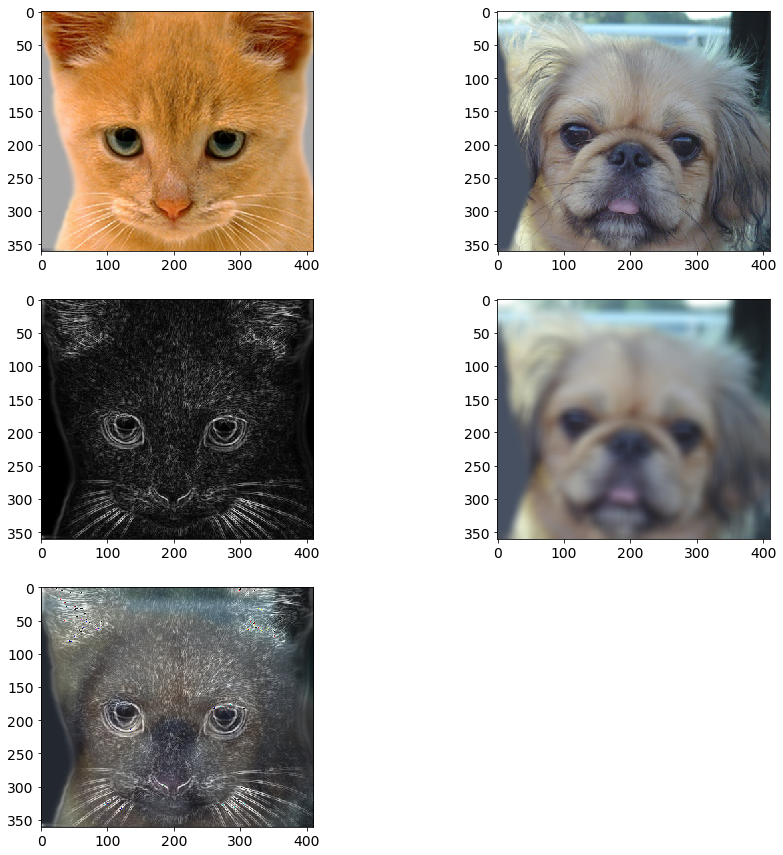

In [177]:
q5_cat = cv2.cvtColor(cv2.imread('imageQ51.jpg'), cv2.COLOR_BGR2RGB)
q5_dog = cv2.cvtColor(cv2.imread('imageQ52.jpg'), cv2.COLOR_BGR2RGB)
q5_pixel_type = type(q5_cat[0][0][0])

# https://docs.opencv.org/master/d5/d0f/tutorial_py_gradients.html
# Laplacian less resistant to noise
q5_hpfx = cv2.Sobel(q5_cat, cv2.CV_64F, 1, 0) 
q5_hpfy = cv2.Sobel(q5_cat, cv2.CV_64F, 0, 1)
q5_hpf = (np.absolute(q5_hpfx/2) + np.absolute(q5_hpfy/2)).astype(q5_pixel_type)
#q5_hpf = cv2.Laplacian(q5_cat, cv2.CV_64F).astype(q5_pixel_type)

q5_hpf = cv2.cvtColor(cv2.cvtColor(q5_hpf, cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
# ^ (make hpf image grayscale for better look)

q5_lpf = cv2.blur(q5_dog, (15,15))
q5_res = (q5_hpf.astype(np.float64) + q5_lpf.astype(np.float64)/2).astype(q5_pixel_type)

q5_imglist = (q5_cat, q5_dog, q5_hpf, q5_lpf, q5_res)
for i in range(len(q5_imglist)):
    plt.subplot(3,2,i+1)
    plt.imshow(q5_imglist[i], cmap=plt.get_cmap('gray'))
